Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 166MB/s]
100%|██████████| 5400/5400 [00:51<00:00, 105.31it/s]



✅ Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.96      0.96       595
              Forest       0.96      0.98      0.97       606
HerbaceousVegetation       0.94      0.94      0.94       602
             Highway       0.92      0.90      0.91       515
          Industrial       0.95      0.98      0.97       493
             Pasture       0.95      0.93      0.94       423
       PermanentCrop       0.92      0.91      0.91       473
         Residential       0.99      0.98      0.98       597
               River       0.92      0.92      0.92       490
             SeaLake       0.99      0.99      0.99       606

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400


✅ Overall Accuracy: 0.9509


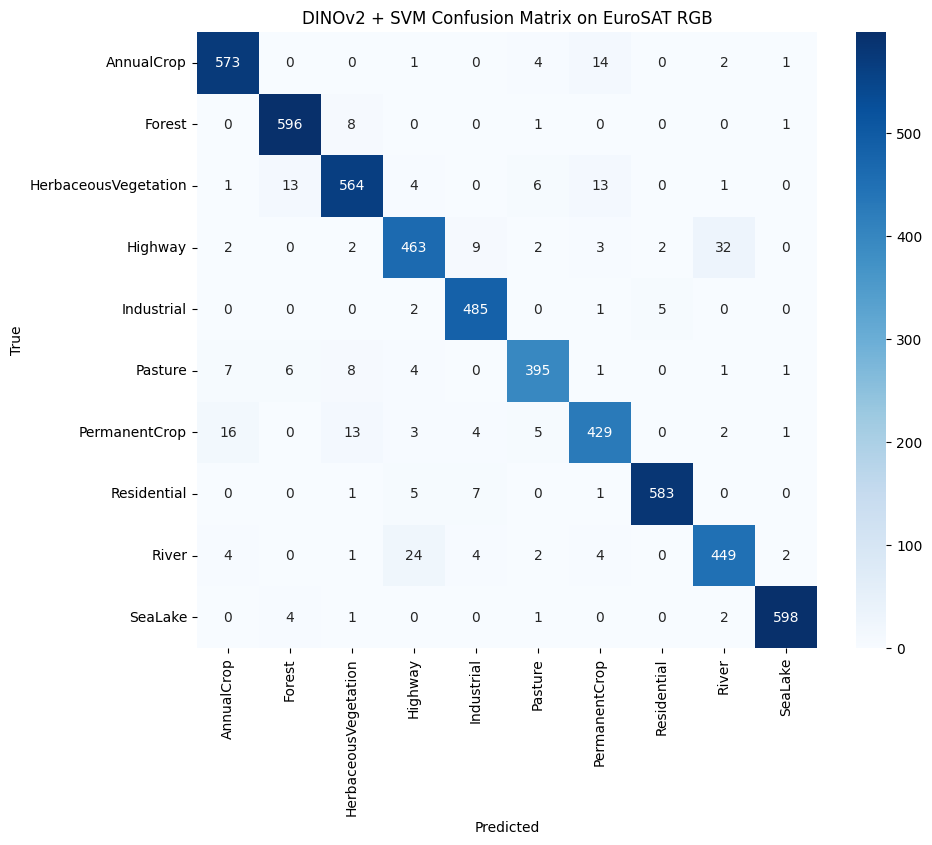


✅ Model and weights saved! Use in Streamlit app for real-time prediction.


In [4]:
# ✅ End-to-End DINOv2 + SVM Classifier for EuroSAT RGB Dataset (Model Training & Save Only)
# Optimized for GIS, Satellite, and Remote Sensing Image Classification

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ✅ Set paths
# IMPORTANT: Unzip EuroSAT RGB and set this to the folder containing 10 subfolders (each class)
data_path = "/content/eurosat_rgb/2750"  # Assuming EuroSAT RGB extracts into a subfolder named '2750'
 # for Colab (adjust if you're using VSCode)

# ✅ Image transformations for DINOv2 input
transform = T.Compose([
    T.Resize(244),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# ✅ Load dataset
dataset = ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes

# ✅ Split dataset into training and test sets
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

# ✅ Load pretrained DINOv2 model
def load_dino_model():
    model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
    model.to(device)
    model.eval()
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino = load_dino_model()

# ✅ Function to extract embeddings
def extract_embeddings(loader):
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for img, label in tqdm(loader):
            img = img.to(device)
            features = dino(img)
            emb = features.cpu().numpy().reshape(-1)
            all_embeddings.append(emb)
            all_labels.append(label.item())
    return np.array(all_embeddings), np.array(all_labels)

# ✅ Extract embeddings
X_train, y_train = extract_embeddings(train_loader)
X_test, y_test = extract_embeddings(test_loader)

# ✅ Train SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

# ✅ Save classifier and label info
joblib.dump(clf, "dino_svm_classifier.pkl")
np.save("class_names.npy", class_names)

# ✅ Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
print(f"\n✅ Overall Accuracy: {accuracy:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DINOv2 + SVM Confusion Matrix on EuroSAT RGB")
plt.savefig("confusion_matrix.png")
plt.show()

print("\n✅ Model and weights saved! Use in Streamlit app for real-time prediction.")

In [3]:
import zipfile
zip_path = "/content/EuroSAT.zip"
extract_path = "/content/eurosat_rgb"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
